<a href="https://colab.research.google.com/github/analystanand/Deep-Learning/blob/master/AlexNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import time
from torchsummary import summary

In [0]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=8, stride=1, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc_base = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.fc_base(x)
        return x

In [3]:
# training data transformation
transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470,0.2435,0.2616))])

# training data loader
train_set = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform_train,)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)



# test data transformation
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435,0.2616))])
# test data loader
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:

def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss,
    total_acc))
    return total_loss, total_acc

In [0]:
def test_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss,total_acc))

    return total_loss, total_acc

In [0]:
def plot_accuracy(test_accuracy: list,train_accuracy,model_name,ep):
    """Plot accuracy"""
    plt.figure()
    x =  range(1,ep+1)
    plt.plot(x,test_accuracy,color='b',label='Test')
    plt.plot(x,train_accuracy,color='r',label='Train')
    plt.title(model_name)
    # plt.xticks(
    #     [i for i in range(0, len(accuracy))],
    #     [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    # plt.show()
    plt.legend()
    plt.savefig('{}.png'.format(model_name))

Model: AlexNET
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 27, 27]          18,528
              ReLU-2           [-1, 96, 27, 27]               0
            Conv2d-3          [-1, 256, 27, 27]         614,656
              ReLU-4          [-1, 256, 27, 27]               0
 LocalResponseNorm-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14    

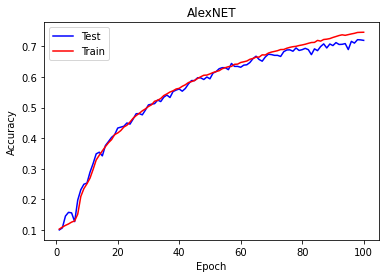

In [7]:
if __name__ == '__main__':
    model = AlexNet(num_classes=10)
    model_name = "AlexNET"
    start_time = time.time()
    print("Model:", model_name)
    # select gpu 0, if available# otherwise fallback to cpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
     # transfer the model to the GPU
    model = model.to(device)
    summary(model, (3, 32, 32))
   
    # loss function
    loss_function = nn.CrossEntropyLoss()
    # We'll optimize all parameters
    optimizer = optim.SGD(model.parameters(),lr=0.0005, momentum=0.9)

    EPOCHS = 100
    test_acc, train_acc = [], []  # collect accuracy for plotting
    for epoch in range(EPOCHS):
        print('Epoch {}/{}'.format(epoch + 1, EPOCHS))
        train_loss, train_accuracy = train_model(model, loss_function, optimizer, train_loader)
        test_loss, test_accuracy = test_model(model, loss_function, test_loader)
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    endtime = time.time() - start_time
    print("Endtime %s seconds", endtime)
    plot_accuracy(test_acc, train_acc, model_name, EPOCHS)